In [1]:
import numpy as np
from numpy import pi
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, quantum_info
from qiskit.providers.aer import Aer
from qiskit import Aer, transpile
from qiskit.tools.visualization import plot_histogram, plot_state_city
from qiskit.circuit.library.standard_gates import HGate,YGate,CXGate,RYGate,CCXGate,XGate,ZGate
import pylatexenc

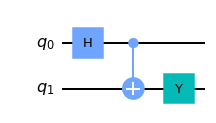

In [2]:
#transformation from |00> to |psi^->:=(|01>-|10>)/sqrt(2)
Vas_q = QuantumRegister(2, 'q')
Vas = QuantumCircuit(Vas_q, name='Vas')
Vas.h(0)
Vas.cnot(0,1)
Vas.y(1)
Vas.draw('mpl')

In [3]:
#CG transform of 1+1 qubits
#Transformation from |i_1 i_2 0> to |j_1 m_1 m_2>
q = QuantumRegister(3, 'q')
CG2 = QuantumCircuit(q, name='CG2')
CG2.ccx(q[0],q[1],q[2])
CG2.cnot(q[1],q[0])
CG2.append(RYGate(pi/2).control(1,ctrl_state=0), [q[2],q[1]])
CG2.append(RYGate(pi/2).control(2,ctrl_state=0), [q[2],q[0],q[1]])
CG2.cx(q[1],q[0],ctrl_state=0)
CG2.swap(q[0],q[1])
CG2.swap(q[1],q[2])

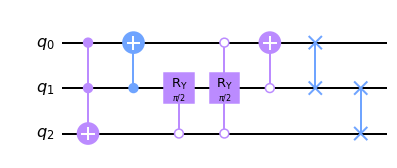

In [4]:
CG2.draw('mpl')

In [5]:
#CG transform of 2+1 qubits
#Transformation from |j_1 m_1 m_2 i_3> to |j'_1 m'_1 m'_2 p'_3>
theta=2.0*np.arccos(np.sqrt(2/3))

q = QuantumRegister(4, 'q')
CG3 = QuantumCircuit(q, name='CG3')

CG3.cnot(q[0],q[2],ctrl_state=0)
CG3.ccx(q[2],q[3],q[1])
CG3.cnot(q[3],q[2])
CG3.cnot(q[1],q[2])
CG3.append(RYGate(pi).control(1,ctrl_state=0),[q[1],q[3]])
CG3.append(RYGate(-theta).control(3,ctrl_state=5),[q[0],q[1],q[2],q[3]])
CG3.append(RYGate(theta).control(3,ctrl_state=7),[q[0],q[1],q[2],q[3]])
CG3.cnot(q[3],q[0])
CG3.x(q[0])
CG3.swap(q[1],q[2])
CG3.x(q[1])
CG3.cx(q[0],q[1])
CG3.cswap(q[0],q[1],q[2])
CG3.ccx(q[0],q[1],q[2])

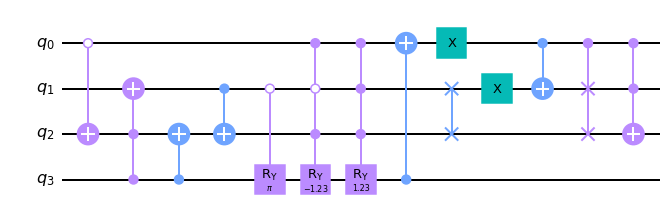

In [6]:
CG3.draw('mpl')

In [7]:
#Input unitary is chosen randomly
Uin =quantum_info.random_unitary(2)

In [8]:
#a block of quantum circuit using 2 calls of the input unitary
q = QuantumRegister(3, 'q')
a = QuantumRegister(4, 'aux')
block = QuantumCircuit(q,a, name='block')

block.unitary(Uin, q[1], label="Uin")
block.append(CG2, [q[0],q[1],a[0]])
block.cx(q[0], a[3], ctrl_state=1)
block.append(CG3.inverse(), [a[1],a[2],q[2],a[3]])
block.unitary(Uin, a[3], label="Uin")
block.append(CG3, [q[0],q[1],a[0],a[3]])
block.cx(a[1],a[3], ctrl_state=1)
block.append(CG2.inverse(), [a[1], a[2], q[2]])
block.swap(a[0],q[0])
block.swap(a[2],q[1])
block.swap(a[1],q[2])

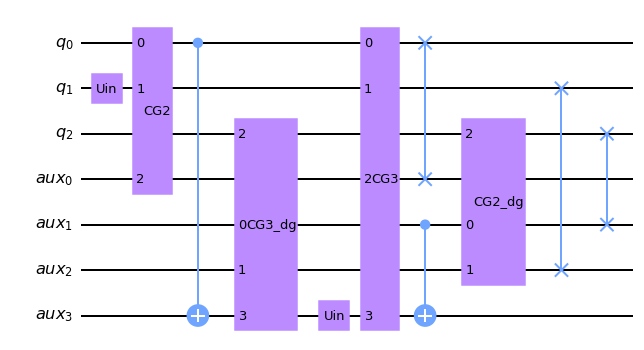

In [9]:
block.draw('mpl')

In [10]:
#Unitary inversion circuit
#Transforming |\psi, 0, 0> to (U\otimes \1)|as>\otimes U^-1 |\psi>
q = QuantumRegister(3, 'q')
a = QuantumRegister(4, 'aux')
circ = QuantumCircuit(q,a,name='circ')

circ.append(Vas,[q[1],q[2]])
circ.append(block, [q[0],q[1],q[2],a[0],a[1],a[2],a[3]])
circ.append(block, [q[0],q[1],q[2],a[0],a[1],a[2],a[3]])

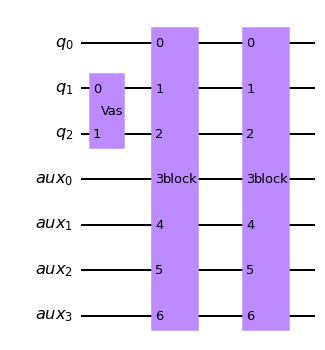

In [11]:
circ.draw('mpl')

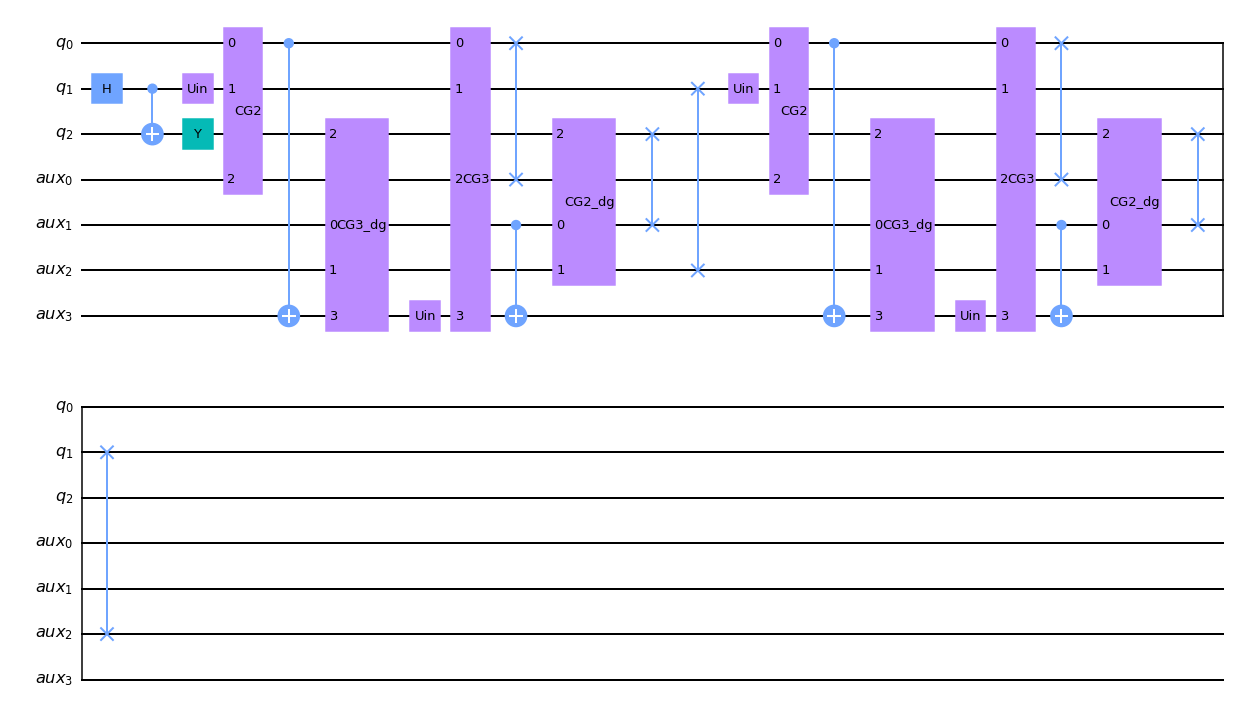

In [12]:
circ=circ.decompose()
circ.draw('mpl')

In [13]:
#Unitary to prepare input state from |0>
prep=quantum_info.random_unitary(2)

In [14]:
#Checking that "circ" implements a transformation from |\psi, 0, 0> to (U\otimes I)|as>\otimes U^-1 |\psi>
q = QuantumRegister(3, 'q')
a = QuantumRegister(4, 'aux')
c = ClassicalRegister(3, 'c')
check_circ = QuantumCircuit(q,a,c)

check_circ.unitary(prep,q[0],label="prep")
check_circ.append(circ, [q[0],q[1],q[2],a[0],a[1],a[2],a[3]])
check_circ.unitary(Uin, q[2], label="Uin")
check_circ.unitary(prep.adjoint(), q[2], label="prep_dg")
check_circ.unitary(Uin.adjoint(), q[0], label='Uin_dg')
check_circ.append(Vas.inverse(), [q[0],q[1]])
check_circ.measure(q[0],c[0])
check_circ.measure(q[1],c[1])
check_circ.measure(q[2],c[2])

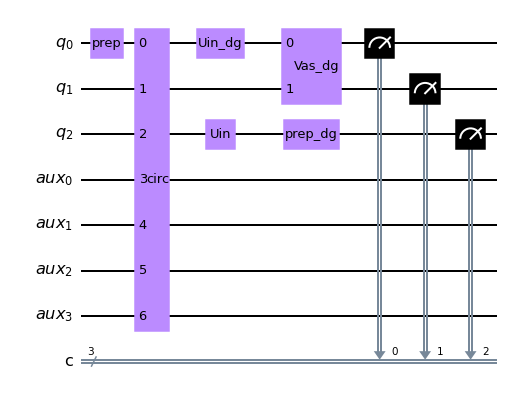

In [15]:
check_circ.draw('mpl')

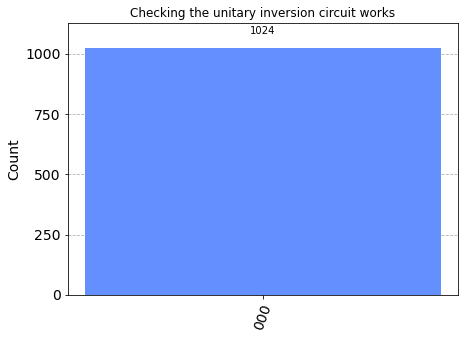

In [16]:
# Transpile for simulator
simulator = Aer.get_backend('aer_simulator')
check_circ = transpile(check_circ, simulator)

# Run and get counts
result = simulator.run(check_circ).result()
counts = result.get_counts(check_circ)
plot_histogram(counts, title='Checking the unitary inversion circuit works')